In [1]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import torch
import pandas as pd
import NN_classes
import NN_evaluation
import training_methods
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Import the original data for plotting
sc = "sc01"
period = "2030"
case = "RTS24"
folder = f"../Data/{case}_DC_fy/"
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
len(all_executions)
executions = all_executions[0:40]
te_s = 0.3
val_s = 0.3
outp = "SystemCosts"

hyperloop_name = f"Decay_rand_Weeks_{case}_DC_0.25_v0.33_PF_0_20"
hyperloop_name = f"Decay_rand_Weeks_{case}_DC_0.25_v0.33_PF_0_74"
hyperloop_name = f"Decay_rand_Weeks_{case}_DC_0.25_v0.33_PF_0_80"

In [10]:
#Analyze the loss results
df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col = 0)
df_losses.columns

Index(['Model_type', 'Dor', 'Relu_out', 'Batch_size', 'Lr', 'Lri', 'Lrs',
       'Lrg', 'Epochs', 'Min_val', 'Nb_hours_used', 'Sel_method',
       'Norm_method', 'Tr_l', 'Te_l', 'V_l', 'Tr_l_mse', 'Te_l_mse', 'V_l_mse',
       'Tr_l_mae', 'Te_l_mae', 'Te_l_mae_man', 'V_l_mae', 'fy_l', 'fy_l_mse',
       'fy_l_mae', 'fy_l_mae_man', 'Train_time', 'Eval_time', 'alpha', 'beta',
       'MAE', 'Test size', 'Val size'],
      dtype='object')

In [11]:
df_losses.sort_values(by="fy_l_mse")

,Model_type,Dor,Relu_out,Batch_size,Lr,Lri,Lrs,Lrg,Epochs,Min_val,...,fy_l_mse,fy_l_mae,fy_l_mae_man,Train_time,Eval_time,alpha,beta,MAE,Test size,Val size
446,"(3, 1)",0,False,128,"(0.0025, 32, 1)",0.0025,32,1.00,64,min_val,...,0.000005,0.000725,0.000725,327.547810,0.064561,0,1,False,0.25,0.333333
455,"(3, 1)",0,False,128,"(0.0025, 32, 0.25)",0.0025,32,0.25,128,all_epochs,...,0.000005,0.000706,0.000706,666.313982,0.060795,0,1,False,0.25,0.333333
454,"(3, 1)",0,False,128,"(0.0025, 32, 0.25)",0.0025,32,0.25,128,min_val,...,0.000005,0.000698,0.000698,666.313982,0.064666,0,1,False,0.25,0.333333
476,"(3, 1)",0,False,128,"(0.0025, 32, 0.25)",0.0025,32,0.25,64,min_val,...,0.000006,0.000793,0.000793,327.896576,0.063863,0,1,False,0.25,0.333333
382,"(3, 1)",0,False,128,"(0.0025, 32, 0.25)",0.0025,32,0.25,128,min_val,...,0.000007,0.000645,0.000645,450.793734,0.045617,0,1,False,0.25,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,"(3, 1)",0,False,128,"(0.01, 32, 0.25)",0.0100,32,0.25,128,all_epochs,...,0.000430,0.015418,0.015418,11.715526,0.005782,0,1,False,0.25,0.333333
146,"(3, 1)",0,False,128,"(0.01, 32, 1)",0.0100,32,1.00,64,min_val,...,0.000432,0.014077,0.014077,13.560811,0.005844,0,1,False,0.25,0.333333
147,"(3, 1)",0,False,128,"(0.01, 32, 1)",0.0100,32,1.00,64,all_epochs,...,0.000435,0.013999,0.013999,13.560811,0.006324,0,1,False,0.25,0.333333
82,"(3, 1)",0,False,128,"(0.01, 32, 0.25)",0.0100,32,0.25,128,min_val,...,0.000437,0.015857,0.015857,11.715526,0.006407,0,1,False,0.25,0.333333


<Axes: xlabel='Nb_hours_used', ylabel='fy_l_mse'>

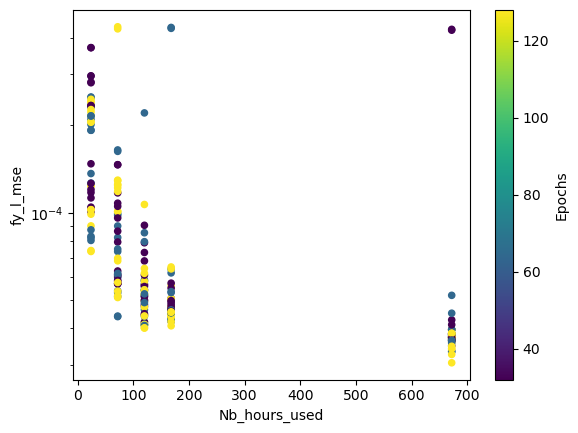

In [19]:
f = df_losses.Nb_hours_used <=1000
df_losses[f].plot.scatter(x="Nb_hours_used",y="fy_l_mse",c = "Epochs",colormap = "viridis",logy = True)

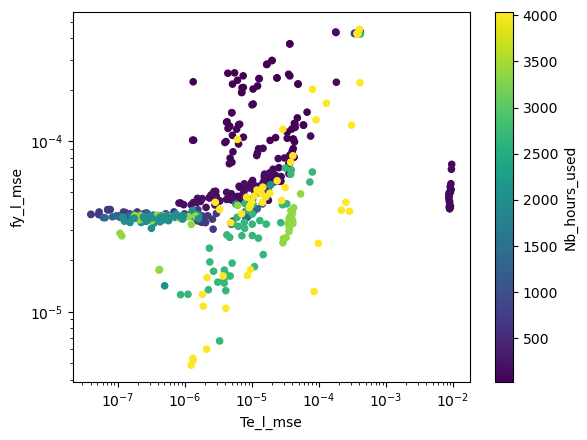

In [20]:
hour_limit = 5000
f = df_losses.Nb_hours_used <= hour_limit
df_losses[f].plot.scatter(x="Te_l_mse",y="fy_l_mse",c = "Nb_hours_used",colormap = "viridis",logy=True,logx=True)
plt.savefig(f"Figures/Hyperparams/Number_hours_analysis/{case}_scatter_Te_l_fy_l_{hour_limit}.png")

In [14]:
f = df_losses.Nb_hours_used<2000
losses_only = df_losses[f][["Te_l_mse","fy_l_mse"]]
losses_only.corr()

,Te_l_mse,fy_l_mse
Te_l_mse,1.000000,-0.114148
fy_l_mse,-0.114148,1.000000


In [3]:
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"])
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter,all_executions)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

#Extract fy sets
t_in_fy, t_out_fy, t_inter_fy, maxs = DataLoading.concat_all_exec_fy(dfs_in, dfs_out, dfs_inter_j,all_executions)

input_f_sc01_Network_Existing_Generation_Full_2030.csv
90
input_f_sc01_Network_Full_Generation_Full_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_101_N_102_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_101_N_103_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_101_N_105_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_102_N_104_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_102_N_106_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_103_N_109_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_103_N_124_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_104_N_109_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_105_N_110_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_106_N_108_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_106_N_110_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_107_N_108_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_108_N_109_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_108_N_110_cac1_2030.csv
90
input_

In [4]:
df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)

f = df_losses.Nb_hours_used >=1

loss_to_sort = "Te_l_mse"

[60, 60, 60, 38, 19]
OE_672hours_(3, 1)h_128e_(0.0025, 32, 0.25)lr_0dor_Falsero_128bs_0ill_FalseMAE min_val
trained_models/Decay_rand_Days_RTS24_DC_0.25_v0.33_PF_0_80/min_val/model_OE_672hours_(3, 1)h_128e_(0.0025, 32, 0.25)lr_0dor_Falsero_128bs_0ill_FalseMAE.pth


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other


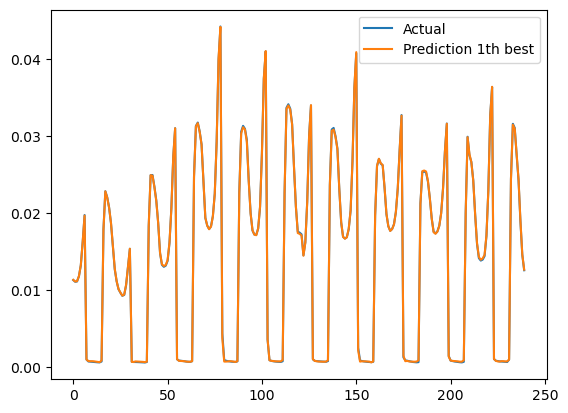

In [6]:
#Visualisation of multiple models in input order
ex = all_executions[4]


#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])
ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in_scalar"])
ex_out = dfs_out[ex].sum(axis=1).to_numpy()


s = 24*10
e=s+24*10
plt.plot(ex_out[s:e]/maxs["out_scalar"],label = "Actual")

for xth_best in [1]: 
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    if row.Sel_method.item() == "Hours": 
        hyperloop_name = f"Decay_rand_Hours_{case}_DC_0.25_v0.33_PF_0_80"
    elif row.Sel_method.item() == "Days":
        hyperloop_name = f"Decay_rand_Days_{case}_DC_0.25_v0.33_PF_0_80"
    else: 
        print("Problem")
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False,hidden_sizes = [60,60,60,38,19])
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
plt.legend()

Network_Existing_Generation_Full
[60, 60, 60, 38, 19]
OE_672hours_(3, 1)h_128e_(0.0025, 32, 0.25)lr_0dor_Falsero_128bs_0ill_FalseMAE min_val
trained_models/Decay_rand_Days_RTS24_DC_0.25_v0.33_PF_0_80/min_val/model_OE_672hours_(3, 1)h_128e_(0.0025, 32, 0.25)lr_0dor_Falsero_128bs_0ill_FalseMAE.pth
Network_Full_Generation_Full
[60, 60, 60, 38, 19]
OE_672hours_(3, 1)h_128e_(0.0025, 32, 0.25)lr_0dor_Falsero_128bs_0ill_FalseMAE min_val
trained_models/Decay_rand_Days_RTS24_DC_0.25_v0.33_PF_0_80/min_val/model_OE_672hours_(3, 1)h_128e_(0.0025, 32, 0.25)lr_0dor_Falsero_128bs_0ill_FalseMAE.pth


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other


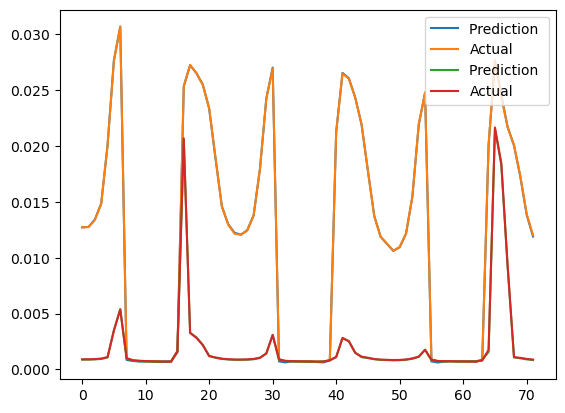

In [10]:
#Visualisation of multiple executions in input order


s = 0
e=s+72


for ex_i in [0,1]:
    ex = all_executions[ex_i]
    print(ex)
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    if row.Sel_method.item() == "Hours": 
        hyperloop_name = f"Decay_rand_Hours_{case}_DC_0.25_v0.33_PF_0_80"
    elif row.Sel_method.item() == "Days":
        hyperloop_name = f"Decay_rand_Days_{case}_DC_0.25_v0.33_PF_0_80"
    else: 
        print("Problem")
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False,hidden_sizes = [60,60,60,38,19])
    ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in_scalar"])
    ex_out = dfs_out[ex].sum(axis=1).to_numpy()/maxs["out_scalar"]
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction ")
    plt.plot(ex_out[s:e],label = f"Actual")

plt.legend()

C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other


Text(0.5, 1.0, 'Derived line benefits')

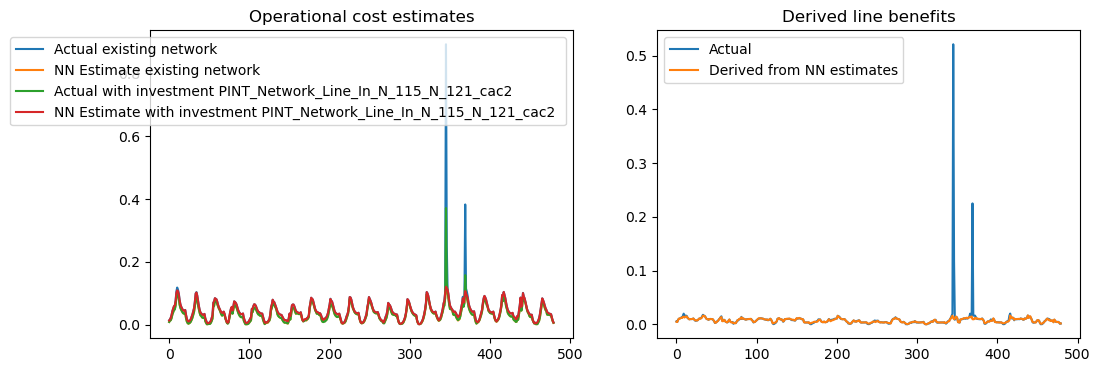

In [29]:
#Visualisation of multiple executions in input order
# f = df_losses.alpha ==0.0
# loss_to_sort = "Te_l_mae"
# xth_best = 1
# row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
# m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False)

#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])

l_idx = 28
ex = all_executions[l_idx]
negf = all_executions[0]


ex_in_e = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in_scalar"])
ex_in_negf = torch.nan_to_num(dfs_in[negf].to_numpy()/maxs["in_scalar"])

prediction_e = m(ex_in_e.float())[0].detach().numpy()
prediction_negf = m(ex_in_negf.float())[0].detach().numpy()

actual_e = NN_evaluation.get_actual_from_dfs_out(ex,dfs_out)/maxs["out_scalar"]
actual_negf = NN_evaluation.get_actual_from_dfs_out(negf,dfs_out)/maxs["out_scalar"]

lb_est = prediction_negf- prediction_e
lb_actual = NN_evaluation.calculate_lb_from_dfs_out(dfs_out,ex)/maxs["out_scalar"]



#s= random.randint(0,len(actual_e))
s=5000
e = s+24*20

fig, axs = plt.subplots(1,2,figsize = (12,4))

axs[0].plot(actual_negf[s:e],label = "Actual existing network")
axs[0].plot(prediction_e[s:e],label = "NN Estimate existing network")
axs[0].plot(actual_e[s:e],label = f"Actual with investment {ex}")
axs[0].plot(prediction_negf[s:e],label = f"NN Estimate with investment {ex} ")

axs[0].legend()
axs[0].set_title("Operational cost estimates")


axs[1].plot(lb_actual[s:e],label = "Actual")
axs[1].plot(lb_est[s:e],label = "Derived from NN estimates")

axs[1].legend()
axs[1].set_title(f"Derived line benefits")

#axs[2].hist(lb_actual/actual_negf,bins= 100)


In [ ]:
#Check loss calculation 
f = df_losses.Nb_hours_used >= 1
loss_to_sort = "fy_l_mse"
xth_best = 1
row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False)
prediction = m(t_in_fy.float())

In [ ]:
s = 0
e = 100
plt.plot(prediction[0].squeeze()[s:e].detach())
plt.plot(t_out_fy[s:e],label = f"Actual")

In [ ]:
#Calculate loss manually 
manual_diff = prediction[0].detach().numpy().transpose() - t_out_fy.numpy()
np.mean(np.abs(manual_diff)),np.mean(np.square(manual_diff))

In [ ]:
row.fy_l_mae.item(),row.fy_l_mse.item()